In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys; sys.path.append("..")
from src.utils import read_data

# Ejercicio 1-a
Implementar un Autoencoder básico para las imagenes de la lista de caracteres del archivo "font.h".

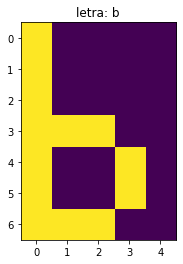

In [2]:
data_dict = read_data("../data/font.csv")
letra = "b"
plt.imshow(data_dict[letra])
plt.title("letra: " + letra)
plt.show()

La arquitectura seleccionada va reduciendo dimensiones de forma progresiva con entradas saturables entre 0 y 1.
Cuando se llega a la capa 3 con 5 neuronas, es posible aprender $2^6$ patrones distintos.
La capa siguiente es lineal o relu para evitar que las salidas queden saturadas y se pierda información. 
Para decodificar la salida se utilizó una arquitectura invertida al codificador.

In [3]:
from src.optimizer import Adam
from src.autoencoder import Autoencoder
from src.perceptron_multicapa import Layer

autoencoder = Autoencoder([
    Layer(35, 20, "sigmoid"),
    Layer(20,  6, "sigmoid"),
    Layer( 6,  2, "linear"),
    Layer( 2,  6, "sigmoid"),
    Layer( 6, 20, "sigmoid"),
    Layer(20, 35, "sigmoid"),
], bottleneck_index=2, loss_fun="bce")

X = np.array(list(data_dict.values()))
X = X.reshape(-1, 5 * 7)

autoencoder.optimizer.learning_rate = 0.005
history = autoencoder.train_autoencoder(X, epochs=2_000, batch_size=1)

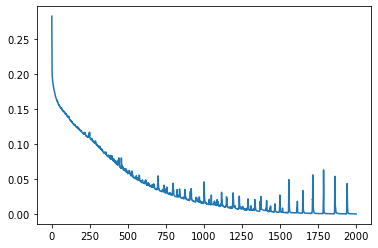

In [4]:
e = [i for i, h in enumerate(history)]
l = [h["train_loss"] for h in history]
plt.plot(e, l)
plt.show()

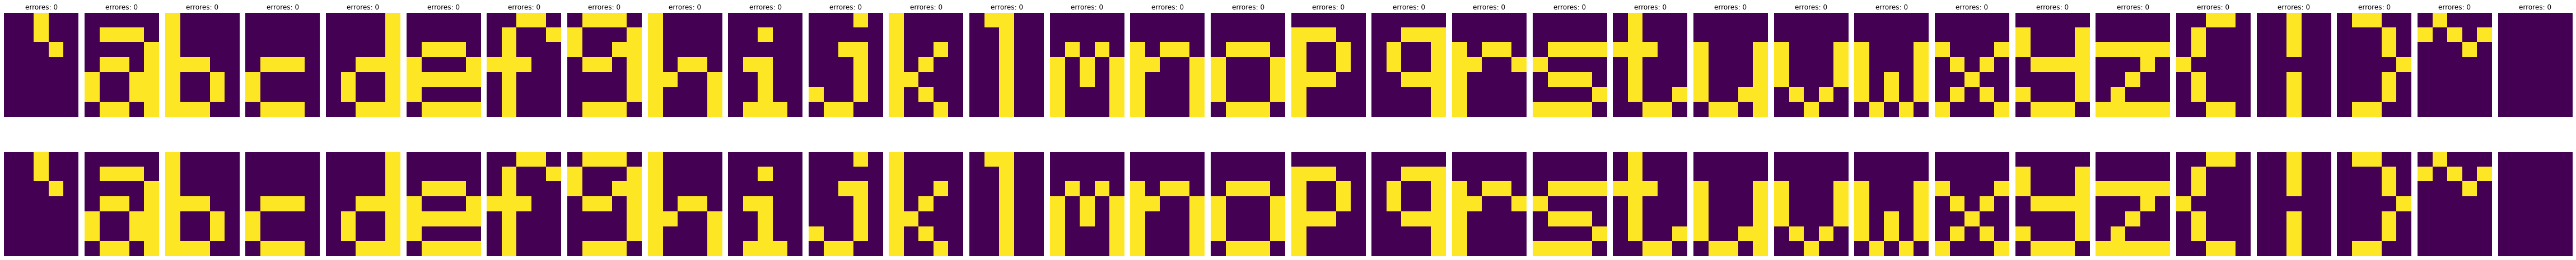

El máximo error alcanzado es 0


In [5]:
indices = 32
fig, ax = plt.subplots(2, indices, figsize=(indices * 2, 8))

max_error = 0
for idx in range(indices):
	threshold = 0.5
	ax[0, idx].imshow(autoencoder.forward(X[idx]).reshape(7, 5) > threshold)
	ax[1, idx].imshow(X[idx].reshape(7, 5))

	ax[0, idx].set_axis_off()
	ax[1, idx].set_axis_off()

	error = sum(abs((autoencoder.forward(X[idx]) > threshold) - X[idx]))
	ax[0, idx].set_title("errores: {}".format(error))
	
	max_error = max(error, max_error)

plt.tight_layout()
plt.show()

print("El máximo error alcanzado es {}".format(max_error))

Se observó que el espacio latente trata de separar lo más posible cada letra.
Sin embargo, hay clusters de grupos de letras similares como:
* b, h
* s, z
* v, u

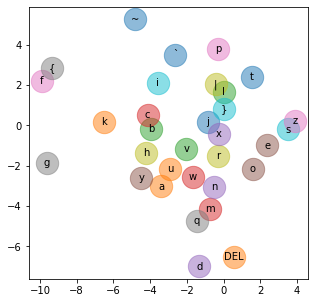

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for letra in data_dict.keys():
	arr = data_dict[letra]
	x, y = autoencoder.encode(arr.reshape(-1))
	plt.scatter(x, y, label=letra, s=500, alpha=0.5, data=letra)
	plt.text(x, y, letra, ha="center", va="center", fontsize=10)
plt.show()

Para armar una letra que no esta en el espacio solución podemos tomar varios puntos aleatorios del espacio latente y observar su salida.

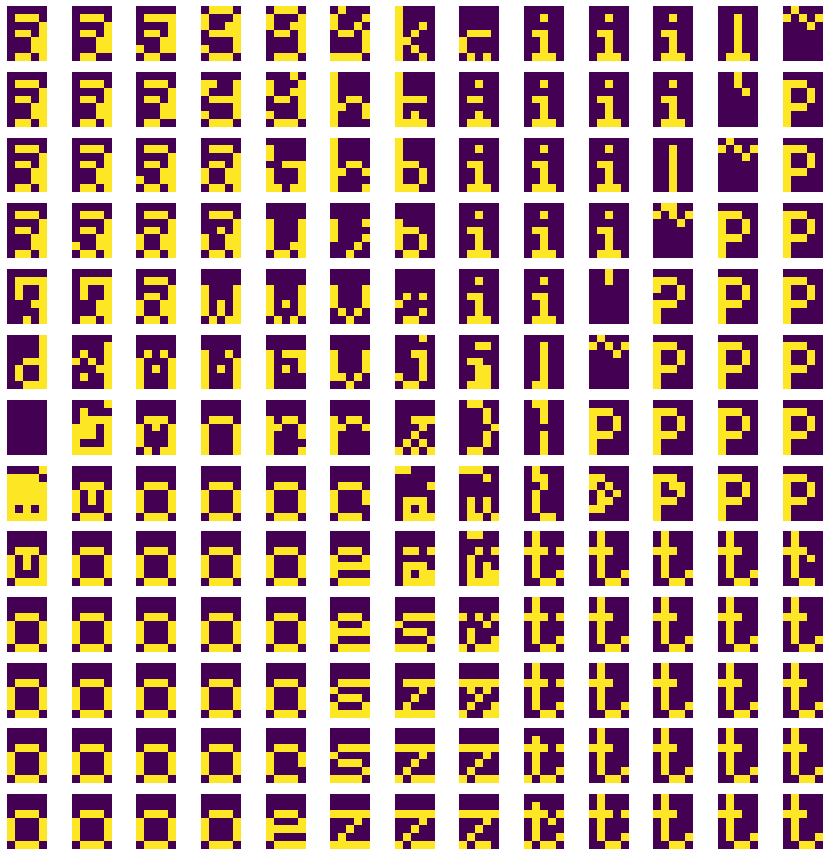

In [7]:
x = np.linspace(-6, 6, 13)
y = np.linspace(-6, 6, 13)

threshold = 0.5

fig, ax = plt.subplots(len(x), len(y), figsize=(12,12))
for i, xi in enumerate(x):
	for j, yj in enumerate(y):
		
		letra = autoencoder.decode([xi, yj]) > threshold
		ax[i, j].imshow(letra.reshape(7, 5))
		ax[i, j].set_axis_off()

plt.tight_layout()
plt.show()

# Ejercicio 1-b
Implementar una variante que implemente un "Denoising Autoencoder".

In [34]:
def add_noise(x, noise_factor):
    x_noisy = x.copy()
    mask = np.random.rand(*x.shape) < noise_factor
    x_noisy[mask] = 1 - x_noisy[mask]  # flip bits
    return x_noisy

In [35]:
X = np.array(list(data_dict.values()))
X = X.reshape(-1, 5 * 7)

noise_level = 0.2

X_out = X
X_noisy = add_noise(X, noise_level)
for _ in range(5):
 	X_out = np.vstack((X_out, X))
 	X_noisy = np.vstack((X_noisy, add_noise(X, noise_level)))


In [36]:
autoencoder = Autoencoder([
    Layer(35, 20, "sigmoid"),
    Layer(20,  6, "sigmoid"),
    Layer( 6, 20, "sigmoid"),
    Layer(20, 35, "sigmoid"),
], bottleneck_index=2, loss_fun="bce")

autoencoder.optimizer.learning_rate = 0.005
history = autoencoder.train_autoencoder(X_noisy, X_out, epochs=250, batch_size=1)

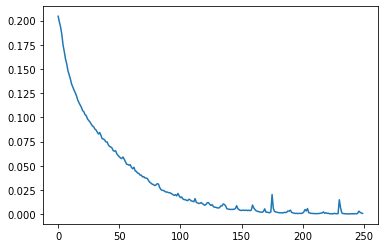

In [37]:
e = [i for i, h in enumerate(history)]
l = [h["train_loss"] for h in history]
plt.plot(e, l)
plt.show()

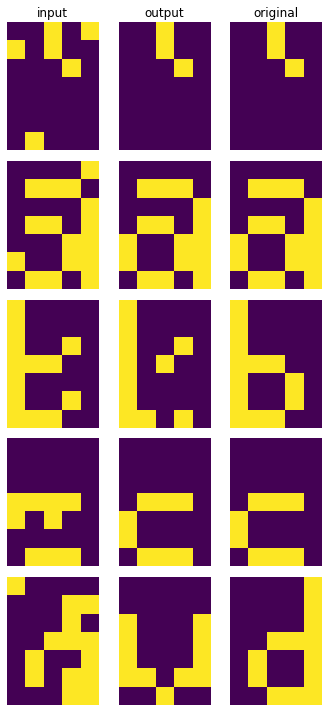

In [33]:
X_noisy = add_noise(X, 0.10)

imagenes = 5
fig, ax = plt.subplots(imagenes, 3, figsize=(5,imagenes*2))

for i in range(imagenes):
	X_out = autoencoder.forward(X_noisy[i])

	ax[i, 0].imshow(X_noisy[i].reshape(7, 5))
	ax[i, 1].imshow(X_out.reshape(7, 5) > 0.5)
	ax[i, 2].imshow(X[i].reshape(7, 5))
	
	ax[i, 0].set_axis_off()
	ax[i, 1].set_axis_off()
	ax[i, 2].set_axis_off()

ax[0, 0].set_title("input")
ax[0, 1].set_title("output")
ax[0, 2].set_title("original")

plt.tight_layout()
plt.show()